In [1]:
import os
import sys
from matplotlib import pyplot as plt
import random
import numpy as np
import pandas as pd
import tqdm
from abc import ABCMeta, abstractmethod, abstractproperty
from copy import copy
%matplotlib inline
plt.style.use("ggplot")
%load_ext autoreload
%autoreload 2

## Exercise 4.9

In [2]:
class FiniteMDP(object):
    def __init__(self,states,actions,rewards,dynamics,terminal_state_vals):
        self.states = states
        self.actions = actions
        self.rewards = rewards
        self.dynamics = dynamics
        self.terminal_state_vals = terminal_state_vals
        
class MDPEnv(metaclass=ABCMeta):
    def __init__(self):
        pass
    
    @abstractmethod
    def get_states(self):
        pass
    
    @abstractmethod
    def get_actions(self):
        pass
    
    @abstractmethod
    def get_rewards(self):
        pass

    @staticmethod
    def get_dynamics(self):
        pass
    
    @staticmethod
    def get_terminal_state_vals(self):
        pass
    
    def get_mdp(self):
        states = self.get_states()
        actions = self.get_actions()
        rewards = self.get_rewards()
        dynamics = self.get_dynamics()
        terminal_state_vals = self.get_terminal_state_vals()
        return FiniteMDP(states,actions,rewards,dynamics,terminal_state_vals)

In [3]:
class GamblerEnv(MDPEnv):
    def __init__(self,ph=0.25,target_chip=100):
        self.ph = ph
        self.target_chip = target_chip
    
    def get_states(self):
        return [i for i in range(self.target_chip + 1)]
    
    def get_actions(self):
        return [i for i in range(1,self.target_chip)]
    
    def get_rewards(self):
        return [0,1]
    
    def get_terminal_state_vals(self):
        return {0:0,100:0}
    
    def get_dynamics_state(self,one_state,one_action):
        assert(one_action <= one_state and one_state <= self.target_chip)
        assert(one_action > 0 and one_state >= 0)
        dynamic_dic = {}
        
        lose_state = one_state - one_action
        win_state = min(self.target_chip,one_state + one_action)
        
        if win_state == self.target_chip:
            dynamic_dic[(win_state,1)] = self.ph
        else:
            dynamic_dic[(win_state,0)] = self.ph
            
        dynamic_dic[(lose_state,0)] = 1 - self.ph
        return dynamic_dic
        
    def get_dynamics(self):
        dynamics = {}
        for one_state in tqdm.tqdm(self.get_states()):
            if one_state == self.target_chip or one_state == 0:
                continue
            dynamics[one_state] = {}
            for one_action in self.get_actions():
                if one_action > one_state:
                    continue
                dynamics[one_state][one_action] = self.get_dynamics_state(one_state,one_action)
        return dynamics

In [4]:
gamblerEnv = GamblerEnv(ph=0.25)
mdp = gamblerEnv.get_mdp()
dynamics = mdp.dynamics

100%|██████████| 101/101 [00:00<00:00, 10152.78it/s]


## policy iteration

In [5]:
class PolicyIterationSolver(object):
    def __init__(self,mdp,ramda=1):
        self.mdp = mdp
        self.dynamics = self.mdp.dynamics
        self.states = self.mdp.states
        
        self.actions = self.mdp.actions
        self.action2ind = dict(zip(self.actions,list(range(len(self.actions)))))
        self.ind2action = dict(zip(list(range(len(self.actions))),self.actions))
        
        self.Q_values = np.zeros([len(self.states),len(self.actions)],dtype=np.float)
        self.strategy = np.ones(len(self.states),dtype=np.int)
        self.ramda = ramda
        
    def policy_evaluation_iter(self):
        delta = 0
        for one_state in self.states:
            if one_state in self.mdp.terminal_state_vals:
                continue
            for one_action in self.dynamics[one_state]:
                action_ind = self.action2ind[one_action]
                q = self.Q_values[one_state][action_ind]
                
                new_q = 0
                for (next_state,reward),prob in self.dynamics[one_state][one_action].items():
                    new_q += (
                            prob * (reward + self.ramda * self.Q_values[next_state,self.action2ind[self.strategy[next_state]]])
                        )
                delta = max(delta,np.abs(q - new_q))
                self.Q_values[one_state][action_ind] = new_q
        return delta
    
    def policy_evaluation(self,eps=0.1,max_step=100):
        for one_step in range(max_step):
            delta = self.policy_evaluation_iter()
            print("delta for step {}: {}".format(one_step + 1,delta))
            if delta < eps:
                break
    
    def policy_improvement(self):
        policy_stable = True
        
        for one_state in self.states:
            if one_state in self.mdp.terminal_state_vals:
                continue
            old_action = self.strategy[one_state]
            
            new_action = None
            max_q = -np.inf
            for one_action in self.dynamics[one_state]:
                action_ind = self.action2ind[one_action]
                qsa = self.Q_values[one_state][action_ind]
                if qsa > max_q:
                    max_q = qsa
                    new_action = one_action
            assert(new_action is not None)
            if new_action != old_action:
                policy_stable = False
            self.strategy[one_state] = new_action
        return policy_stable
    
    def solve(self,steps=100):
        for state,value in self.mdp.terminal_state_vals.items():
            self.Q_values[state,:] = value
        
        current_step = 0
        while current_step < steps:
            current_step += 1
            print("Evaluating,step {}".format(current_step))
            self.policy_evaluation()
            policy_stable = self.policy_improvement()
            print("Improved,step {}".format(current_step))
            if policy_stable:
                break

In [6]:
pis = PolicyIterationSolver(mdp)

In [7]:
pis.solve(100)

Evaluating,step 1
delta for step 1: 0.25
delta for step 2: 0.0625
Improved,step 1
Evaluating,step 2
delta for step 1: 0.583740234375
delta for step 2: 0.14007568359375
delta for step 3: 0.00732421875
Improved,step 2
Evaluating,step 3
delta for step 1: 0.15435791015625
delta for step 2: 0.0146942138671875
Improved,step 3
Evaluating,step 4
delta for step 1: 0.03369140625
Improved,step 4
Evaluating,step 5
delta for step 1: 0.0068206787109375
Improved,step 5
Evaluating,step 6
delta for step 1: 0.0029301100876182318
Improved,step 6
Evaluating,step 7
delta for step 1: 0.0020870542066404596
Improved,step 7
Evaluating,step 8
delta for step 1: 0.0005303466205077711
Improved,step 8
Evaluating,step 9
delta for step 1: 3.673369064927101e-06
Improved,step 9
Evaluating,step 10
delta for step 1: 7.842318154871464e-07
Improved,step 10
Evaluating,step 11
delta for step 1: 1.2531108950497583e-07
Improved,step 11
Evaluating,step 12
delta for step 1: 3.1327772376243956e-08
Improved,step 12
Evaluating,step

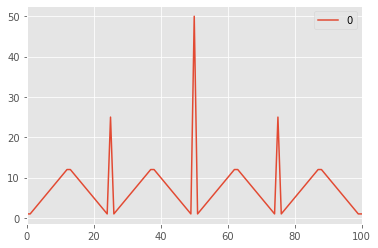

In [8]:
pd.DataFrame(pis.strategy).plot()

## value iteration

In [9]:
class ValueIterationSolver(object):
    def __init__(self,mdp,ramda=1,theta=0.001):
        self.mdp = mdp
        self.dynamics = self.mdp.dynamics
        self.states = self.mdp.states
        
        self.actions = self.mdp.actions
        self.action2ind = dict(zip(self.actions,list(range(len(self.actions)))))
        self.ind2action = dict(zip(list(range(len(self.actions))),self.actions))
        
        self.V = np.zeros(len(self.states),dtype=np.float)
        self.strategy = np.ones(len(self.states),dtype=np.int)
        self.ramda = ramda
        self.theta = theta
        
    def solve_one_epoch(self):
        delta = 0
        for one_state in self.states:
            if one_state in self.mdp.terminal_state_vals:
                continue
            
            v = self.V[one_state]
            new_action = None
            max_v = -np.inf
            
            for one_action in self.dynamics[one_state]:
                action_ind = self.action2ind[one_action]
                
                action_v = 0
                for (next_state,reward),prob in self.dynamics[one_state][one_action].items():
                    action_v += prob * (reward + self.ramda * self.V[next_state])
                if action_v > max_v:
                    max_v = action_v
                    new_action = one_action
            
                    
            delta = max(delta,np.abs(v - max_v))
            self.V[one_state] = max_v
            self.strategy[one_state] = new_action
        return delta
    
    
    def solve(self,steps=100):
        for state,value in self.mdp.terminal_state_vals.items():
            self.V[state] = value
        
        current_step = 0
        while current_step < steps:
            current_step += 1
            delta = self.solve_one_epoch()
            print("Value itered delta {},step {}".format(delta,current_step))
            if delta < self.theta:
                break

In [17]:
gamblerEnv = GamblerEnv(ph=0.55)
mdp = gamblerEnv.get_mdp()
dynamics = mdp.dynamics

100%|██████████| 101/101 [00:00<00:00, 2799.58it/s]


In [18]:
vis = ValueIterationSolver(mdp)

In [19]:
vis.solve()

Value itered delta 0.991696234375,step 1
Value itered delta 0.5398509531250001,step 2
Value itered delta 0.2900956093750001,step 3
Value itered delta 0.15955258515625007,step 4
Value itered delta 0.08775392183593754,step 5
Value itered delta 0.04826465700976565,step 6
Value itered delta 0.015224352343750011,step 7
Value itered delta 0.01076971062580051,step 8
Value itered delta 0.010124195187359408,step 9
Value itered delta 0.009579907118642927,step 10
Value itered delta 0.009054600806272739,step 11
Value itered delta 0.008637622755887198,step 12
Value itered delta 0.008236638977621169,step 13
Value itered delta 0.00789205871563703,step 14
Value itered delta 0.007603619523461336,step 15
Value itered delta 0.007338835721420189,step 16
Value itered delta 0.007105248122453611,step 17
Value itered delta 0.006884045591395882,step 18
Value itered delta 0.0066635158411388895,step 19
Value itered delta 0.0064741073332332255,step 20
Value itered delta 0.006330431328930075,step 21
Value itered d

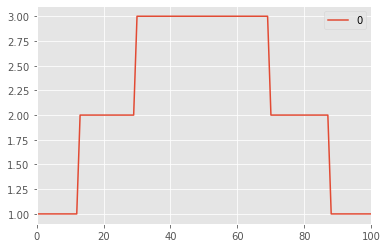

In [20]:
pd.DataFrame(vis.strategy).plot()

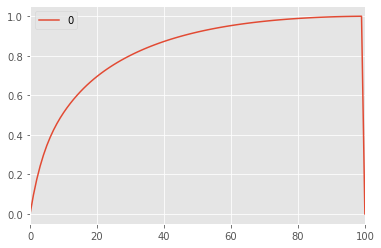

In [22]:
pd.DataFrame(vis.V).plot()